We want a figure that displays application speedup/slowdown from the following input:
%computation & %communication
message size
computational speedup
communication speedup

First with no computation/comm. overlap.
Second with some fixed amount of overlap.

Color can be the speedup or slowdown


In [1]:
%matplotlib inline

CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary
message_size = 8
comp_frac = 0.5
comm_frac = 1-comp_frac

In [2]:
#Returns communication time in nanoseconds
#If our application issues single messages, i.e. not throughput or message rate bound.
def timeToGetMessageSummit(m, h_or_d="default", verbose=False):
    #LogGOP parameter values NVSHMEM Host Initiated (ns)
    L_nvshmem_hi = 530
    o_nvshmem_hi = 1580
    O_nvshmem_hi = 0.085 * m
    g_nvshmem_hi = 5
    G_nvshmem_hi = m / NETWORKBWGBPS

    #LogGOP parameter values NVSHMEM Dev. Initiated (ns)
    L_nvshmem_di = 530
    o_nvshmem_di = 10200
    O_nvshmem_di = 0.075 * m
    g_nvshmem_di = 5
    G_nvshmem_di = m / NETWORKBWGBPS
    
    #LogGOP parameter values IB verbs and DRAM (ns)
    L_nvshmem_dram = 280
    o_nvshmem_dram = 1400
    O_nvshmem_dram = 0.081 * m
    g_nvshmem_dram = 5
    G_nvshmem_dram = m / NETWORKBWGBPS
    
    if h_or_d == "d":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_di , o_nvshmem_di , O_nvshmem_di , g_nvshmem_di , G_nvshmem_di))
        return L_nvshmem_di + o_nvshmem_di + O_nvshmem_di + g_nvshmem_di + G_nvshmem_di

    elif h_or_d == "h":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{} KernelLaunch:{}".format(L_nvshmem_hi , o_nvshmem_hi , O_nvshmem_hi , g_nvshmem_hi , G_nvshmem_hi , (GPUKERNELUS * 1000)))
        return L_nvshmem_hi + o_nvshmem_hi + O_nvshmem_hi + g_nvshmem_hi + G_nvshmem_hi + (GPUKERNELUS * 1000)
    #default MPI performance
    else:
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_dram , o_nvshmem_dram , O_nvshmem_dram , g_nvshmem_dram , G_nvshmem_dram ))
        return L_nvshmem_dram + o_nvshmem_dram + O_nvshmem_dram + g_nvshmem_dram + G_nvshmem_dram

In [197]:
timeToGetMessageSummit(8, "h")

7116.32

In [11]:
def log_10_product(x):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

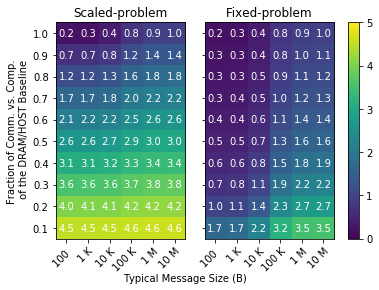

In [56]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

h_or_d = "h"

msg_sizes = [10**x for x in range(2,8)]
comm_ratios = np.arange(1,0,-.1)

normalized_t = 1

speedups1 = []
for i in range(len(comm_ratios)):
    speedups1.append([0]*len(msg_sizes))
    idx_i = 0
for comm_frac in comm_ratios:
    idx_j = 0
    for m in msg_sizes:
        #Need to use reciprical for latency because increase to latency is a slowdown
        comp_frac = 1-comm_frac
        comm_scaling = 1/(timeToGetMessageSummit(m, h_or_d)/timeToGetMessageSummit(m))
        gpu_dev_t = comm_frac*comm_scaling + comp_frac*COMPSCALING
        #print("{}, {}".format(idx_i,idx_j))
        speedups1[idx_i][idx_j] = gpu_dev_t
        idx_j += 1
    idx_i += 1

fig, (ax1, ax2) = plt.subplots(1,2)
im = ax1.imshow(speedups1, vmin=0, vmax=5)

# We want to show all ticks...
ax1.set_xticks(np.arange(len(msg_sizes)))
ax1.set_yticks(np.arange(len(comm_ratios)))
# ... and label them with the respective list entries
ax1.set_xticklabels([log_10_product(m) for m in msg_sizes])
ax1.set_yticklabels([round(number,1) for number in comm_ratios])
ax1.set_ylabel("Fraction of Comm. vs. Comp.\n of the DRAM/HOST Baseline")
#ax1.set_xlabel("Typical Message Size (B)")
# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comm_ratios)):
    for j in range(len(msg_sizes)):
        text = ax1.text(j, i, round(speedups1[i][j],1),
                    ha="center", va="center", color="w")
ax1.set_ylim(len(speedups1)-0.5, -0.5)
ax1.set_title("Scaled-problem")

speedups2 = []
for i in range(len(comm_ratios)):
    speedups2.append([0]*len(msg_sizes))
    idx_i = 0
for comm_frac in comm_ratios:
    idx_j = 0
    for m in msg_sizes:
        comp_frac = 1-comm_frac
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummit(m, h_or_d)/timeToGetMessageSummit(m))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        speedups2[idx_i][idx_j] = cpu_time/gpu_time
        idx_j += 1
    idx_i += 1

im = ax2.imshow(speedups2, vmin=0, vmax=5)

# We want to show all ticks...
ax2.set_xticks(np.arange(len(msg_sizes)))
ax2.set_yticks(np.arange(len(comm_ratios)))
# ... and label them with the respective list entries
ax2.set_xticklabels([log_10_product(m) for m in msg_sizes])
#ax2.set_yticklabels([round(number,1) for number in comm_ratios])
#ax2.set_ylabel("Fraction of Comm. vs. Comp.\n(of CPU baseline)")
ax2.label_outer()
#ax2.set_xlabel("Typical Message Size (B)")
# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comm_ratios)):
    for j in range(len(msg_sizes)):
        text = ax2.text(j, i, round(speedups2[i][j],1),
                    ha="center", va="center", color="w")
#This is to handle a bug in the current matplotlib
fig.text(0.5, 0.01, 'Typical Message Size (B)', ha='center')
ax2.set_ylim(len(speedups2)-0.5, -0.5)
ax2.set_title("Fixed-problem")
#formatter = plt.FuncFormatter(log_10_product)
#ax.xaxis.set_major_formatter(formatter)
plt.subplots_adjust(wspace=-.8)
plt.colorbar(im)
#ax.set_title("Weak-scaled Speedup on {} TFLOPs GPU \n({}X Comp Speedup, Host Initiated Comm., {} us kernel sync)".format(GPUFLOPS, GPUFLOPS/CPUFLOPS, GPUKERNELUS))
fig.tight_layout()
plt.show()
fig.savefig("{}TFGPUSpeedupVs{}TFCPUHostInit{}usKern.png".format(GPUFLOPS, CPUFLOPS, GPUKERNELUS))

In [53]:
s1flat = [t for row in speedups1 for t in row ]
s2flat = [t for row in speedups2 for t in row ]
print(np.mean(s1flat))
print(np.mean(s2flat))

2.5744038076159113
1.1861981237013985


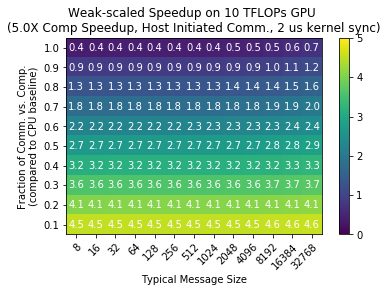

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2
GPUKERNELUS = 2
h_or_d = "h"

msg_sizes = [2**x for x in range(3,16)]
comm_ratios = np.arange(1,0,-.1)

normalized_t = 1

speedups = []
for i in range(len(comm_ratios)):
    speedups.append([0]*len(msg_sizes))
    idx_i = 0
for comm_frac in comm_ratios:
    idx_j = 0
    for m in msg_sizes:
        #Need to use reciprical for latency because increase to latency is a slowdown
        comp_frac = 1-comm_frac
        comm_scaling = 1/(timeToGetMessageSummit(m, h_or_d)/timeToGetMessageSummit(m))
        gpu_dev_t = comm_frac*comm_scaling + comp_frac*COMPSCALING
        #print("{}, {}".format(idx_i,idx_j))
        speedups[idx_i][idx_j] = gpu_dev_t
        idx_j += 1
    idx_i += 1

fig, ax = plt.subplots()
im = ax.imshow(speedups, vmin=0, vmax=5)

# We want to show all ticks...
ax.set_xticks(np.arange(len(msg_sizes)))
ax.set_yticks(np.arange(len(comm_ratios)))
# ... and label them with the respective list entries
ax.set_xticklabels(msg_sizes)
ax.set_yticklabels([round(number,1) for number in comm_ratios])
ax.set_ylabel("Fraction of Comm. vs. Comp.\n(compared to CPU baseline)")
ax.set_xlabel("Typical Message Size")
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comm_ratios)):
    for j in range(len(msg_sizes)):
        text = ax.text(j, i, round(speedups[i][j],1),
                    ha="center", va="center", color="w")
#This is to handle a bug in the current matplotlib
ax.set_ylim(len(speedups)-0.5, -0.5)
plt.colorbar(im)
ax.set_title("Weak-scaled Speedup on {} TFLOPs GPU \n({}X Comp Speedup, Host Initiated Comm., {} us kernel sync)".format(GPUFLOPS, GPUFLOPS/CPUFLOPS, GPUKERNELUS))
fig.tight_layout()
plt.show()
fig.savefig("{}TFGPUSpeedupVs{}TFCPUHostInit{}usKern.png".format(GPUFLOPS, CPUFLOPS, GPUKERNELUS))
GPUKERNELUS = 5

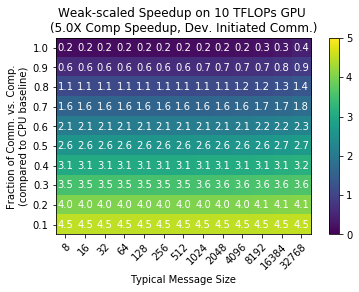

In [5]:
h_or_d = "d"

msg_sizes = [2**x for x in range(3,16)]
comm_ratios = np.arange(1,0,-.1)

normalized_t = 1

speedups = []
for i in range(len(comm_ratios)):
    speedups.append([0]*len(msg_sizes))
    idx_i = 0
for comm_frac in comm_ratios:
    idx_j = 0
    for m in msg_sizes:
        #Need to use reciprical for latency because increase to latency is a slowdown
        comp_frac = 1-comm_frac
        comm_scaling = 1/(timeToGetMessageSummit(m, h_or_d)/timeToGetMessageSummit(m))
        gpu_dev_t = comm_frac*comm_scaling + comp_frac*COMPSCALING
        #print("{}, {}".format(idx_i,idx_j))
        speedups[idx_i][idx_j] = gpu_dev_t
        idx_j += 1
    idx_i += 1

fig, ax = plt.subplots()
im = ax.imshow(speedups, vmin=0, vmax=5)

# We want to show all ticks...
ax.set_xticks(np.arange(len(msg_sizes)))
ax.set_yticks(np.arange(len(comm_ratios)))
# ... and label them with the respective list entries
ax.set_xticklabels(msg_sizes)
ax.set_yticklabels([round(number,1) for number in comm_ratios])
ax.set_ylabel("Fraction of Comm. vs. Comp.\n(compared to CPU baseline)")
ax.set_xlabel("Typical Message Size")
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comm_ratios)):
    for j in range(len(msg_sizes)):
        text = ax.text(j, i, round(speedups[i][j],1),
                    ha="center", va="center", color="w")
#This is to handle a bug in the current matplotlib
ax.set_ylim(len(speedups)-0.5, -0.5)
plt.colorbar(im)
ax.set_title("Weak-scaled Speedup on {} TFLOPs GPU \n({}X Comp Speedup, Dev. Initiated Comm.)".format(GPUFLOPS, GPUFLOPS/CPUFLOPS))
fig.tight_layout()
plt.show()
fig.savefig("{}TFGPUSpeedupVs{}TFCPUDevInit.png".format(GPUFLOPS, CPUFLOPS))